In [199]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.stats as stats
import bspline
import bspline.splinelab as splinelab

from sklearn.preprocessing import MinMaxScaler

In [200]:
data=pd.read_csv(<path to SovereignData.csv>)
# [Year	    Total Assets	Log Return	Yearly Volatility	Quarterly Volatility	Distress Barrier	Risk-free Rate	    mu      Moody]
#   0          1                2            3                      4                   5                       6            7        8

# print(data.head)

<Figure size 900x400 with 0 Axes>

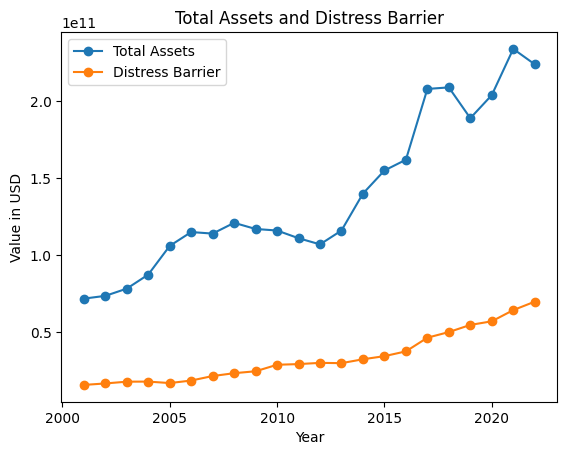

In [201]:
df=data[['Year', 'Total Assets', 'Distress Barrier']]
df.set_index('Year', inplace=True)

# Create the line plot with markers
plt.figure(figsize=(9, 4))  # Set the figure size

lines = df.plot(marker='o', linestyle='-')  # Plot lines with markers

# Add labels and title
plt.ylabel('Value in USD')
plt.title('Total Assets and Distress Barrier')
plt.legend()

# Customize plot (optional)
# You can further customize the plot using matplotlib functions here

# Show the plot
plt.show()

In [202]:
results=pd.DataFrame([], columns=['Year', 'Yearly Volatility', 'Quarterly Volatility', 'Quarter', 'N(d1)', 'd1', 'd2', 'N(-d2)', 'N(d1) Set2', 'd1 Set2', 'd2 Set2', 'N(-d2) Set2'])
# we will have 5 values per year, per simulation, qtr num onwards all unique

In [203]:
prices = pd.DataFrame([], columns=['Year', 'Total Assets', 'Distress Barrier', 'LCL 1', 'LCL 2', 'Mean LCL', 'Std LCL'])

In [204]:
NormalizedProbability = pd.DataFrame([], columns=['Year', 'Moody Rating', 'N(-d2) Set 1', 'N(-d2) Set 2'])

In [205]:
T = 4
M = 1         # maturity
N_MC = 1000   # number of paths


delta_t = M / T                # time interval


# Define the risk aversion parameter
risk_lambda = 0.001 # risk aversion parameter
reg_param = 1e-3

# disturbance level eta: Each action is multiplied by a uniform r.v. in the interval [1-eta, 1 + eta]
eta = 0.1

In [206]:
# To get meaninful results, one should have ncolloc >= p+1
p = 4 # order of spline (as-is; 3: cubic, 4: B-spline?)
ncolloc = 12

num_t_steps = T + 1
num_basis =  ncolloc


In [207]:
seed=42
seed_1=84

# standard normal random numbers
np.random.seed(seed)  # You can use any integer as a seed
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

np.random.seed(seed_1)  # You can use any integer as a seed
RN_1 = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

Load RN from memory

In [208]:
# print(RN.head)
# print(RN_1.head)

In [209]:
def terminal_payoff(ST, K):
    # ST   final stock price    # K    strike
    payoff = max(ST-K, 0)
    return payoff


# functions to compute optimal hedges
def function_A_vec(t,delta_S_hat,data_mat_t):
    # Compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    X_mat = data_mat_t[t,:,:]
    num_basis_funcs = X_mat.shape[1]
    this_dS = delta_S_hat.loc[:,t].values
    hat_dS2 = (this_dS**2).reshape(-1,1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_funcs)
    return A_mat


def function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, mu, r):
    # coef = 1.0/(2 * gamma * risk_lambda)
    coef=0
    tmp =  Pi_hat.loc[:,t+1] * delta_S_hat.loc[:,t] + coef * (np.exp(mu*delta_t) - np.exp(r*delta_t))* S.loc[:,t]
    X_mat = data_mat_t[t,:,:]  # matrix of dimension N_MC x num_basis
    B = np.dot(X_mat.T, tmp)
    return B

In [210]:
def function_C_vec(t,data_mat_t,reg_param):
    # Compute the matrix A_{nm} from Eq. (52) (with a regularization!)
    X_mat = data_mat_t[t,:,:]
    num_basis_funcs = X_mat.shape[1]
    C_mat = np.dot(X_mat.T, X_mat) + reg_param * np.eye(num_basis_funcs)
    return C_mat

def function_D_vec(t, Q, R, data_mat_t, gamma):
    X_mat = data_mat_t[t,:,:]
    tmp = R.loc[:,t] + gamma * Q.loc[:,t+1]  # note that the second argument in Q is t+1 !
    D = np.dot(X_mat.T, tmp.values)
    return D

In [211]:
# vectorized functions

def function_S_vec(t,S_t_mat,reg_param):
    # Compute the matrix S_{nm} from Eq. (75) (with a regularization!)
    S_mat = S_t_mat[:,:,t]
    S_mat_reg = S_mat + reg_param * np.eye(S_mat.shape[0])
    return S_mat_reg

# this function requires some refinement!
def function_M_vec(t,
                   Q_star, # max_Q_star,
                   R,
                   Psi_mat_t,  # 2D array of dimension 3M x num_MC
                   gamma):

    # Psi_mat = Psi_mat_t[:,:,t]   # 2D array of dimension 3M x num_MC
    tmp = R.loc[:,t] + gamma * Q_star.iloc[:,t+1]
    M_t = np.dot(Psi_mat_t, tmp.values)
    return M_t

In [212]:
# The Black-Scholes prices
def bs_put(t, S0, K, r, sigma):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0, K, r, sigma):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

In [213]:
for i in range(1, 22): #use this to mean from 2002 to 2022
    
    ycnt=i
    print("\nSimulation", i,"/21: Year: ", i+2001 )

    year=data.iloc[i, 0]            #year

    S0=data.iloc[i, 1]                 #total asset value
    S0=S0/1000000000

    # log_return=data.iloc[i, 2]    #log return

    sigma=data.iloc[i, 3]           #yearly volatility

    sigma_qtr=data.iloc[i, 4]       #quartely volatility

    K=data.iloc[i, 5]       #distress barrier
    K=K/1000000000

    r=data.iloc[i, 6]       #risk free rate
    r=r/100

    mu=data.iloc[i, 7]      # drift

    moody_cat=data.iloc[i, 8]

    gamma = np.exp(- r * delta_t)  # discount factor





    S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    S.loc[:,0] = S0

    S_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    S_1.loc[:,0] = S0

    for t in range(1, T+1):
      S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])
      S_1.loc[:,t] = S_1.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN_1.loc[:,t])

    delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
    delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)
    X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S.astype(float) / 1.0)  # delta_t here is due to their conventions

    delta_S_1 = S_1.loc[:,1:T].values - np.exp(r * delta_t) * S_1.loc[:,0:T-1]
    delta_S_hat_1 = delta_S_1.apply(lambda x: x - np.mean(x), axis=0)
    X_1 = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_1.astype(float) / 1.0)

    # if ycnt>=20:
    #   # plot 25 paths
    #   step_size = N_MC // 25
    #   idx_plot = np.arange(step_size, N_MC, step_size)
    #   plt.plot(S.T.iloc[:, idx_plot])
    #   plt.xlabel('Quarters')
    #   plt.title('Asset Value Sample Paths')
    #   plt.show()

    #   plt.plot(X.T.iloc[:, idx_plot])
    #   plt.xlabel('Quarters')
    #   plt.ylabel('State Variable')
    #   plt.title('State Variable Sample Paths')
    #   plt.show()
    

    X_min = np.min(np.min(X))
    X_max = np.max(np.max(X))
    tau = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we would like to interpolate
    k = splinelab.aptknt(tau, p)
    # Spline basis of order p on knots k
    basis = bspline.Bspline(k, p)
    # f = plt.figure()
    # basis.plot()


    # Compute the data matrix
    data_mat_t = np.zeros((num_t_steps, N_MC, num_basis))
    data_mat_t_1 = np.zeros((num_t_steps, N_MC,num_basis ))

    for i in np.arange(num_t_steps):
      x = X.values[:,i]
      basis_arr=np.array([ basis(i) for i in x ])
      data_mat_t[i,:,:] = basis_arr

      x_1 = X_1.values[:,i]
      data_mat_t_1[i,:,:] = np.array([ basis(i) for i in x_1 ])


    # Compute optimal hedge and portfolio value

    # DP1
    Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
    Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])
    a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    a.iloc[:,-1] = 0

    # DP2
    Pi_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_1.iloc[:,-1] = S_1.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
    Pi_hat_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_hat_1.iloc[:,-1] = Pi_1.iloc[:,-1] - np.mean(Pi_1.iloc[:,-1])
    a_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    a_1.iloc[:,-1] = 0

    # Off Policy 1
    a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    a_op.iloc[:,-1] = 0
    Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
    Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])
    R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

    # Off Policy 2
    a_op_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    a_op_1.iloc[:,-1] = 0
    Pi_op_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_op_1.iloc[:,-1] = S_1.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))
    Pi_op_hat_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Pi_op_hat_1.iloc[:,-1] = Pi_op_1.iloc[:,-1] - np.mean(Pi_op_1.iloc[:,-1])
    R_op_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    R_op_1.iloc[:,-1] = - risk_lambda * np.var(Pi_op_1.iloc[:,-1])


    for t in range(T-1, -1, -1):
      # DP1
      A_mat = function_A_vec(t, delta_S_hat, data_mat_t)
      B_vec = function_B_vec(t, Pi_hat, delta_S_hat, S, data_mat_t, gamma, mu, r)
      A_mat = np.array(A_mat, dtype=float)
      B_vec = np.array(B_vec, dtype=float)
      phi = np.dot(np.linalg.inv(A_mat), B_vec)
      a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
      Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
      Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])
      # print(np.mean(a.iloc[:,t]))
      

      # DP2
      A_mat_1 = function_A_vec(t,delta_S_hat_1,data_mat_t_1)
      B_vec_1 = function_B_vec(t, Pi_hat_1, delta_S_hat_1, S_1, data_mat_t_1, gamma, mu, r)
      A_mat_1 = np.array(A_mat_1, dtype=float)
      B_vec_1 = np.array(B_vec_1, dtype=float)
      phi_1 = np.dot(np.linalg.inv(A_mat_1), B_vec_1)
      a_1.loc[:,t] = np.dot(data_mat_t_1[t,:,:],phi_1)
      Pi_1.loc[:,t] = gamma * (Pi_1.loc[:,t+1] - a_1.loc[:,t] * delta_S_1.loc[:,t])
      Pi_hat_1.loc[:,t] = Pi_1.loc[:,t] - np.mean(Pi_1.loc[:,t])


      noise_factors = np.random.uniform(low=1-eta, high=1+eta, size=N_MC)

      # Off Policy 1
      a_op.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
      a_op.loc[:, t] = noise_factors * a_op.loc[:, t]
      Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
      Pi_op_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])
      R_op.loc[1:,t] = gamma * a_op.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi_op.loc[1:,t])

      # Off Policy 2
      a_op_1.loc[:,t] = np.dot(data_mat_t_1[t,:,:],phi_1)
      a_op_1.loc[:, t] = noise_factors * a_op_1.loc[:, t]
      Pi_op_1.loc[:,t] = gamma * (Pi_op_1.loc[:,t+1] - a_op_1.loc[:,t] * delta_S_1.loc[:,t])
      Pi_op_hat_1.loc[:,t] = Pi_op_1.loc[:,t] - np.mean(Pi_op_1.loc[:,t])
      R_op_1.loc[1:,t] = gamma * a_op_1.loc[1:,t] * delta_S_1.loc[1:,t] - risk_lambda * np.var(Pi_op_1.loc[1:,t])

    # print('inner loop done!')

    # # plot 25 paths
    # if ycnt>=20:
    #   step_size = N_MC // 25
    #   idx_plot = np.arange(step_size, N_MC, step_size)
    #   plt.plot(a.T.iloc[:,idx_plot])
    #   plt.xlabel('Quarters')
    #   plt.title('Optimal Hedge')
    #   plt.show()

    #   plt.plot(Pi.T.iloc[:,idx_plot])
    #   plt.xlabel('Quarters')
    #   plt.title('Portfolio Value')
    #   plt.show()


    # save dp solution
    a_dp = a.copy()
    a_dp_1 = a_1.copy()

    # overwrite dp variables (on-policy)vars with off policy variables
    a = a_op.copy()
    Pi = Pi_op.copy()
    Pi_hat = Pi_op_hat.copy()
    R = R_op.copy()

    a_1 = a_op_1.copy()
    Pi_1 = Pi_op_1.copy()
    Pi_hat_1 = Pi_op_hat_1.copy()
    R_1 = R_op_1.copy()

    num_MC = a.shape[0]

    ones_3d = np.ones((1,num_MC, T+1))
    # make matrix A_t of shape (3 x num_MC x num_steps)
    num_MC = a.shape[0]
    a_1_1 = a.values.reshape((1,num_MC,T+1))
    a_1_2 = 0.5 * a_1_1**2
    A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

    # and the same for the second dataset:
    a_2_1 = a_1.values.reshape((1,num_MC,T+1))
    a_2_2 = 0.5 * a_2_1**2
    A_stack_1 = np.vstack((ones_3d, a_2_1, a_2_2))

    data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)
    data_mat_swap_idx_1 = np.swapaxes(data_mat_t_1,0,2)

    # expand dimensions of matrices to multiply element-wise
    A_2 = np.expand_dims(A_stack, axis=1) # becomes (3,1,1000,5)
    data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0)  # becomes (1,12,1000,5)
    Psi_mat = np.multiply(A_2, data_mat_swap_idx) # this is a matrix of size 3 x num_basis x num_MC x num_steps

    # now concatenate columns along the first dimension
    Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F')

    # the same for the twin dataset
    A_2_1 = np.expand_dims(A_stack_1, axis=1)
    data_mat_swap_idx_1 = np.expand_dims(data_mat_swap_idx_1, axis=0)
    Psi_mat_1 = np.multiply(A_2_1, data_mat_swap_idx_1) # this is a matrix of size 3 x num_basis x num_MC x num_steps

    # now concatenate columns along the first dimension
    Psi_mat_1 = Psi_mat_1.reshape(-1, N_MC, T+1, order='F')

    # make matrix S_t
    Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
    Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
    S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2)

    Psi_1_aux_1 = np.expand_dims(Psi_mat_1, axis=1)
    Psi_2_aux_1 = np.expand_dims(Psi_mat_1, axis=0)
    S_t_mat_1 = np.sum(np.multiply(Psi_1_aux_1, Psi_2_aux_1), axis=2)

    del Psi_1_aux, Psi_2_aux, Psi_1_aux_1, Psi_2_aux_1, data_mat_swap_idx,data_mat_swap_idx_1, A_2, A_2_1

    # implied Q-function by input data (using the first form in Eq.(68))
    Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

    # similar variables for the twin dataset:
    Q_RL_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Q_RL_1.iloc[:,-1] = - Pi_1.iloc[:,-1] - risk_lambda * np.var(Pi_1.iloc[:,-1])

    # optimal action
    a_opt = np.zeros((N_MC,T+1))
    a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    a_star.iloc[:,-1] = 0

    # optimal action
    a_opt_1 = np.zeros((N_MC,T+1))
    a_star_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    a_star_1.iloc[:,-1] = 0

    # optimal Q-function with optimal action
    Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

    # optimal Q-function with optimal action
    Q_star_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
    Q_star_1.iloc[:,-1] = Q_RL_1.iloc[:,-1]

    max_Q_star = np.zeros((N_MC,T+1))
    max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

    max_Q_star_1 = np.zeros((N_MC,T+1))
    max_Q_star_1[:,-1] = Q_RL_1.iloc[:,-1].values

    num_basis = data_mat_t.shape[2]

    # The backward loop
    for t in range(T-1, -1, -1):
      # calculate vector W_t
      S_mat_reg = function_S_vec(t,S_t_mat,reg_param)
      M_t = function_M_vec(t,Q_star, R, Psi_mat[:,:,t], gamma)

      S_mat_reg = np.array(S_mat_reg, dtype=float)
      M_t = np.array(M_t, dtype=float)

      W_t = np.dot(np.linalg.inv(S_mat_reg),M_t)  # this is an 1D array of dimension 3M

      # reshape to a matrix W_mat
      W_mat = W_t.reshape((3, num_basis), order='F')  # shape 3 x M

      # make matrix Phi_mat
      Phi_mat = data_mat_t[t,:,:].T  # dimension M x N_MC

      # compute matrix U_mat of dimension N_MC x 3
      U_mat = np.dot(W_mat, Phi_mat)

      # twin variables for the twin dataset:
      S_mat_reg_1 = function_S_vec(t,S_t_mat_1,reg_param)
      M_t_1 = function_M_vec(t,Q_star_1, R_1, Psi_mat_1[:,:,t], gamma)
      S_mat_reg_1 = np.array(S_mat_reg_1, dtype=float)
      M_t_1 = np.array(M_t_1, dtype=float)
      W_t_1 = np.dot(np.linalg.inv(S_mat_reg_1),M_t_1)  # this is an 1D array of dimension 3M

      # reshape to a matrix W_mat
      W_mat_1 = W_t_1.reshape((3, num_basis), order='F')  # shape 3 x M

      # make matrix Phi_mat
      Phi_mat_1 = data_mat_t_1[t,:,:].T  # dimension M x N_MC

      # compute matrix U_mat_1 of dimension N_MC x 3
      U_mat_1 = np.dot(W_mat_1, Phi_mat_1)

      # compute vectors U_W^0,U_W^1,U_W^2 as rows of matrix U_mat
      U_W_0 = U_mat[0,:]
      U_W_1 = U_mat[1,:]
      U_W_2 = U_mat[2,:]

      U_W_0_1 = U_mat_1[0,:]
      U_W_1_1 = U_mat_1[1,:]
      U_W_2_1 = U_mat_1[2,:]

      a_opt[:,t] = np.dot(data_mat_t[t,:,:], phi)
      a_star.loc[:,t] = a_opt[:,t]

      a_opt_1[:,t] = np.dot(data_mat_t_1[t,:,:], phi_1)
      a_star_1.loc[:,t] = a_opt_1[:,t]

      max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2
      max_Q_star_1[:,t] = U_W_0_1 + a_opt_1[:,t] * U_W_1_1 + 0.5 * (a_opt_1[:,t]**2) * U_W_2_1

      # update dataframes
      Q_star.loc[:,t] = max_Q_star[:,t]

      # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
      Psi_t = Psi_mat[:,:,t].T  # dimension N_MC x 3M
      Q_RL.loc[:,t] = np.dot(Psi_t, W_t)

      a_star_1.loc[:,t] = a_opt_1[:,t]
      Q_star_1.loc[:,t] = max_Q_star_1[:,t]

      # update the Q_RL solution given by a dot product of two matrices W_t Psi_t
      Psi_t_1 = Psi_mat_1[:,:,t].T  # dimension N_MC x 3M
      Q_RL_1.loc[:,t] = np.dot(Psi_t_1, W_t_1)

      # trim outliers for Q_RL
      up_percentile_Q_RL =  95 # 95
      low_percentile_Q_RL = 5 # 5

      low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])

      # trim outliers in values of max_Q_star:
      flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
      flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
      Q_RL.loc[flag_lower,t] = low_perc_Q_RL
      Q_RL.loc[flag_upper,t] = up_perc_Q_RL

      low_perc_Q_RL_1, up_perc_Q_RL_1 = np.percentile(Q_RL_1.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])

      # trim outliers in values of max_Q_star:
      flag_lower_1 = Q_RL_1.loc[:,t].values < low_perc_Q_RL_1
      flag_upper_1 = Q_RL_1.loc[:,t].values > up_perc_Q_RL_1
      Q_RL_1.loc[flag_lower_1,t] = low_perc_Q_RL_1
      Q_RL_1.loc[flag_upper_1,t] = up_perc_Q_RL_1

    # print("fitted q loop done")





    # dp1

    Nd1_dp_1 = (a.mean()).astype(float)

    Nd1_1=Nd1_dp_1[:4]
    # print("Nd1_1", Nd1_1)

    d1_dp_1 = stats.zscore(Nd1_1)

    d2_dp_1 = d1_dp_1.copy()
    Nd2_dp_1 = d1_dp_1.copy()





    # dp2

    Nd1_dp_2 = (a_1.mean()).astype(float)

    Nd1_2=Nd1_dp_2[:4]
    # print("Nd1_2", Nd1_2)

    d1_dp_2 = stats.zscore(Nd1_2)

    d2_dp_2 = d1_dp_1.copy()
    Nd2_dp_2 = d1_dp_1.copy()






    # loop for calculation
    for qtr in range(0,T):

      # dp1
      d2_dp_1[qtr]=d1_dp_1[qtr] - sigma_qtr * np.sqrt((T-qtr)/T)
      Nd2_dp_1[qtr]=norm.cdf(-d2_dp_1[qtr])


      # dp2
      d2_dp_2[qtr]=d1_dp_2[qtr]-sigma_qtr * np.sqrt((T-qtr)/T)
      Nd2_dp_2[qtr]=norm.cdf(-d2_dp_2[qtr])

    nd2_sum=0
    nd2_sum_set2=0

    # loop for data entry
    for qtr in range(0,T):
      # print to res matrix


      nd2_sum+=Nd2_dp_1[qtr]
      nd2_sum_set2+=Nd2_dp_2[qtr]

      new_res_row = {
        'Year': year,
        'Yearly Volatility': sigma,
        'Quarterly Volatility': sigma_qtr,
        'Quarter': qtr,
        'N(d1)': Nd1_dp_1[qtr],
        'd1': d1_dp_1[qtr],
        'd2': d2_dp_1[qtr],
        'N(-d2)': Nd2_dp_1[qtr],
        'N(d1) Set2': Nd1_dp_2[qtr],
        'd1 Set2': d1_dp_2[qtr],
        'd2 Set2': d2_dp_2[qtr],
        'N(-d2) Set2': Nd2_dp_2[qtr]
      }
      new_row_df = pd.DataFrame([new_res_row])
      results = pd.concat([results, new_row_df], ignore_index=False)

    new_norm_row={
      'Year': year,
      'Moody Rating': moody_cat,
      'N(-d2) Set 1': nd2_sum/5,
      'N(-d2) Set 2': nd2_sum_set2/5,
    }
    new_row_df = pd.DataFrame([new_norm_row])
    NormalizedProbability = pd.concat([NormalizedProbability, new_row_df], ignore_index=False)


    # QLBS option price
    C_QLBS = - Q_star.copy()
    qlbs_price_1 = np.mean(C_QLBS.iloc[:,0])

    C_QLBS_1 = - Q_star_1.copy()
    qlbs_price_2 = np.mean(C_QLBS_1.iloc[:,0])

    QLBS_prices = np.array([C_QLBS.iloc[0,0],C_QLBS_1.iloc[0,0]])
    qlbs_mean_price = np.mean(QLBS_prices)
    qlbs_std_price = np.std(QLBS_prices)

    new_price_row = {
      'Year': year,
      'Total Assets': S0,
      'Distress Barrier': K,
      'LCL 1': qlbs_price_1,
      'LCL 2': qlbs_price_2,
      'Mean LCL': qlbs_mean_price,
      'Std LCL': qlbs_std_price
    }
    new_row_df = pd.DataFrame([new_price_row])
    prices = pd.concat([prices, new_row_df], ignore_index=False)



    print('---------------------------------')
    print('       QLBS RL Option Pricing       ')
    print('---------------------------------\n')
    print('%-25s' % ('Initial Stock Price:'), S0)
    # print('%-25s' % ('Drift of Stock:'), mu)
    print('%-25s' % ('Volatility of Stock:'), sigma)
    print('%-25s' % ('Risk-free Rate:'), r)
    print('%-25s' % ('Risk aversion parameter :'), risk_lambda)
    print('%-25s' % ('Strike:'), K)
    # print('%-25s' % ('Maturity:'), M)
    print('%-26s %.4f' % ('\nThe QLBS Call Price 1 :', (np.mean(C_QLBS.iloc[:,0]))))
    print('%-26s %.4f' % ('The QLBS Call Price 2 :', (np.mean(C_QLBS_1.iloc[:,0]))))


    QLBS_prices = np.array([C_QLBS.iloc[0,0],C_QLBS_1.iloc[0,0]])
    mean_price = np.mean(QLBS_prices)
    std_price = np.std(QLBS_prices)

    print('%-26s  %.4f +/- %.4f ' % ('\nQLBS Call Price: ',mean_price,std_price ))
    print('%-26s %.4f' % ('\nBlack-Scholes Call Price:', bs_call(0, S0, K, r, sigma)))
    print('\n')




Simulation 1 /21: Year:  2002


C:\Users\Victus\AppData\Local\Temp\ipykernel_17488\1642864078.py:444: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row_df], ignore_index=False)
C:\Users\Victus\AppData\Local\Temp\ipykernel_17488\1642864078.py:453: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  NormalizedProbability = pd.concat([NormalizedProbability, new_row_df], ignore_index=False)
C:\Users\Victus\AppData\Local\Temp\ipykernel_17488\1642864078.py:477: FutureWarning: The behavior of DataFrame con

---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      73.535346705
Volatility of Stock:      0.280336608
Risk-free Rate:           0.08710000000000001
Risk aversion parameter : 0.001
Strike:                   16.622163564

The QLBS Call Price 1 :   51.9036
The QLBS Call Price 2 :    54.7011

QLBS Call Price:           53.3024 +/- 1.3987 

Black-Scholes Call Price: 61.8054



Simulation 2 /21: Year:  2003
---------------------------------
       QLBS RL Option Pricing       
---------------------------------

Initial Stock Price:      78.235030416
Volatility of Stock:      0.50400319
Risk-free Rate:           0.05502
Risk aversion parameter : 0.001
Strike:                   17.776465778

The QLBS Call Price 1 :   53.0132
The QLBS Call Price 2 :    64.7671

QLBS Call Price:           58.8902 +/- 5.8769 

Black-Scholes Call Price: 64.5463



Simulation 3 /21: Year:  2004
---------------------------------
       

In [214]:
print(NormalizedProbability)

#currently has three columns, year, nd2 set 1, nd2 set 2                                +3

#step 0: should also have moody's own ratings                                           +1

#step 1: add min max normalized values for these themselves                             +2

#step 2: come up with a scheme to generate categorical moody ratings for each set       +2

#step 3: convert the categories to numerical values for moody, set 1, set2              +3

# Step 4: euclidean distance between  
            # norm moody, norm moody set1 
            # norm moody, norm moody set 2
            # norm set 1, norm moody set 1
            # norm set 2, norm moody set 2



   Year Moody Rating  N(-d2) Set 1  N(-d2) Set 2
0  2002           B3      0.442194      0.449011
0  2003           B2      0.473330      0.447694
0  2004           B2      0.491120      0.465891
0  2005           B2      0.493344      0.489569
0  2006           B1      0.485557      0.477811
0  2007           B1      0.477278      0.477866
0  2008           B3      0.489226      0.469036
0  2009           B3      0.502079      0.473611
0  2010           B3      0.501108      0.472757
0  2011           B3      0.500731      0.476728
0  2012         Caa1      0.500511      0.476637
0  2013         Caa1      0.501106      0.473399
0  2014         Caa1      0.506390      0.487264
0  2015           B3      0.510862      0.485243
0  2016           B3      0.493781      0.481833
0  2017           B3      0.515333      0.503434
0  2018           B3      0.512557      0.500515
0  2019           B3      0.515779      0.509992
0  2020           B3      0.514257      0.505631
0  2021           B3

In [215]:
scaler=MinMaxScaler()
NormalizedProbability['Normalized N(-d2) Set 1'] = scaler.fit_transform(NormalizedProbability[['N(-d2) Set 1']])
NormalizedProbability['Normalized N(-d2) Set 2'] = scaler.fit_transform(NormalizedProbability[['N(-d2) Set 2']])


In [216]:
def default_risk_rating(probability):
    ratings = {
        'B1': (0.0, 0.25),  # highest rating
        'B2': (0.25, 0.5),
        'B3': (0.5, 0.75),
        'Caa1': (0.75, 1.0)  # lowest rating
    }
    for rating, (lower, upper) in ratings.items():
        if lower <= probability <= upper:
            return rating
    return 'Unknown'

In [217]:
NormalizedProbability['Moody Set 1'] = NormalizedProbability['Normalized N(-d2) Set 1'].apply(default_risk_rating)
NormalizedProbability['Moody Set 2'] = NormalizedProbability['Normalized N(-d2) Set 2'].apply(default_risk_rating)

# NormalizedProbability['Moody Set 1'] = NormalizedProbability['N(-d2) Set 1'].apply(default_risk_rating)
# NormalizedProbability['Moody Set 2'] = NormalizedProbability['N(-d2) Set 2'].apply(default_risk_rating)


In [218]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Create a LabelEncoder object
le = LabelEncoder()

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Define the ratings in order from best to worst
ratings = ['B1', 'B2', 'B3', 'Caa1']

# Encode and normalize each column
for col in ['Moody Rating', 'Moody Set 1', 'Moody Set 2']:

    # Encode the ratings
    NormalizedProbability[f'{col}_encoded'] = le.fit_transform(NormalizedProbability[col])

    # Normalize the encoded values
    NormalizedProbability[f'{col}_normalized'] = scaler.fit_transform(NormalizedProbability[[f'{col}_encoded']])

In [219]:

# Calculate Euclidean distances
NormalizedProbability['Euc_Set1-vs-Moody'] = NormalizedProbability.apply(lambda row: np.linalg.norm([row['Moody Rating_normalized'], row['Moody Set 1_normalized']]), axis=1)
NormalizedProbability['Euc_Set1-vs-Moody'] = NormalizedProbability.apply(lambda row: np.linalg.norm([row['Moody Rating_normalized'], row['Moody Set 2_normalized']]), axis=1)
NormalizedProbability['Euc_Set1-vs-NormSet1'] = NormalizedProbability.apply(lambda row: np.linalg.norm([row['Normalized N(-d2) Set 1'], row['Moody Set 1_normalized']]), axis=1)
NormalizedProbability['Euc_Set2-vs-NormSet2'] = NormalizedProbability.apply(lambda row: np.linalg.norm([row['Normalized N(-d2) Set 2'], row['Moody Set 2_normalized']]), axis=1)

NormalizedProbability['Euc_Set1-vs-Nd2_1'] = NormalizedProbability.apply(lambda row: np.linalg.norm([row['N(-d2) Set 1'], row['Moody Set 1_normalized']]), axis=1)
NormalizedProbability['Euc_Set2-vs-Nd2_2'] = NormalizedProbability.apply(lambda row: np.linalg.norm([row['N(-d2) Set 2'], row['Moody Set 2_normalized']]), axis=1)

In [220]:
print(results.head(8))


   Year  Yearly Volatility  Quarterly Volatility Quarter     N(d1)        d1  \
0  2002           0.280337              0.140168       0  0.847867 -0.592249   
0  2002           0.280337              0.140168       1  0.873149  0.155697   
0  2002           0.280337              0.140168       2  0.830360 -1.110202   
0  2002           0.280337              0.140168       3  0.920168  1.546755   
0  2003           0.504003              0.252002       0  0.847491 -0.793931   
0  2003           0.504003              0.252002       1  0.896845 -0.094643   
0  2003           0.504003              0.252002       2  0.848934 -0.773484   
0  2003           0.504003              0.252002       3  1.020829  1.662058   

         d2    N(-d2)  N(d1) Set2   d1 Set2   d2 Set2  N(-d2) Set2  
0 -0.732418  0.768043    0.839465 -0.724187 -0.864355     0.806304  
0  0.034307  0.486316    0.903491  1.626236  1.504847     0.066182  
0 -1.209316  0.886729    0.859449  0.009443 -0.089671     0.535726  
0  

In [221]:
print(prices.head(8))

   Year  Total Assets  Distress Barrier       LCL 1       LCL 2    Mean LCL  \
0  2002     73.535347         16.622164   51.903635   54.701077   53.302356   
0  2003     78.235030         17.776466   53.013213   64.767112   58.890162   
0  2004     87.355506         17.833508   74.733092   78.657105   76.695099   
0  2005    106.000000         16.877445  150.413057  159.813166  155.113111   
0  2006    115.000000         18.517387  122.073856   83.611381  102.842618   
0  2007    114.000000         21.442069  120.305913  132.240777  126.273345   
0  2008    121.000000         23.291327  116.479497  174.868359  145.673928   
0  2009    117.000000         24.542066  140.231803  113.640456  126.936129   

     Std LCL  
0   1.398721  
0   5.876950  
0   1.962007  
0   4.700055  
0  19.231238  
0   5.967432  
0  29.194431  
0  13.295673  


In [222]:
print(NormalizedProbability)


   Year Moody Rating  N(-d2) Set 1  N(-d2) Set 2  Normalized N(-d2) Set 1  \
0  2002           B3      0.442194      0.449011                 0.000000   
0  2003           B2      0.473330      0.447694                 0.423130   
0  2004           B2      0.491120      0.465891                 0.664885   
0  2005           B2      0.493344      0.489569                 0.695117   
0  2006           B1      0.485557      0.477811                 0.589287   
0  2007           B1      0.477278      0.477866                 0.476786   
0  2008           B3      0.489226      0.469036                 0.639148   
0  2009           B3      0.502079      0.473611                 0.813819   
0  2010           B3      0.501108      0.472757                 0.800630   
0  2011           B3      0.500731      0.476728                 0.795503   
0  2012         Caa1      0.500511      0.476637                 0.792517   
0  2013         Caa1      0.501106      0.473399                 0.800598   

In [223]:
NormalizedProbability.to_csv('Probabilities.csv')

results.to_csv('Variables.csv')

prices.to_csv('LCL.csv')
